# Internal Resistance Calculation for Small Vertical Axis Wind Turbine
**Author:** Ian Eykamp, **Date:** 6/7/2023

## Purpose
All generators have some amount of internal resistance, which allows there to be a variable voltage drop across the terminals, even if the generator always outputs the same emf. By connecting various resistors across the terminals (using no resistance as a baseline), I can figure out what the internal resistance is.

### Import libraries
`plecs_helper.py` is a file I created which defines some helper functions for nice plots and getting data off the oscilloscope and out of PLECS.

In [67]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
from UliEngineering.EngineerIO import format_value
from si_prefix import si_format
import plecs_helper as helper
%matplotlib
%matplotlib inline

# Imports and setup
from pint import UnitRegistry
from scipy.signal import find_peaks
from scipy.optimize import fsolve

# pandas display using scientific notation
# pd.set_option('display.float_format', lambda x: f'{x:.3e}')

# use pint
units = UnitRegistry()
units.default_format = "~P.2f"

def to_decibels(arr, dc_gain = 0):
    return np.log10(np.abs(arr)) * 20 + dc_gain

Using matplotlib backend: TkAgg


Newfile1.csv: unloaded
Newfile2.csv: 100kOhm
Newfile3.csv: 100Ohm
Newfile4.csv: 100Ohm / 2
Newfile5.csv: 24Ohm
Newfile6.csv: 6.8Ohm

In [68]:
# Import data
(df_1, tspan, tstep) = helper.read_rigol_csv("oscilloscope_data/unloaded.csv", ch1 = "unloaded")
(df_2, tspan, tstep) = helper.read_rigol_csv("oscilloscope_data/100Ohm.csv", ch1 = "100Ohm")
(df_3, tspan, tstep) = helper.read_rigol_csv("oscilloscope_data/6_8Ohm.csv", ch1 = "6.8Ohm")
(df_4, tspan, tstep) = helper.read_rigol_csv("oscilloscope_data/4_5Ohm.csv", ch1 = "4.5Ohm")

# Combine all variables into one for convenience
df = df_1.set_index("t").join([df_2.set_index("t"), df_3.set_index("t"), df_4.set_index("t")]).reset_index()
print(df.head(20))

        t  unloaded  100Ohm  6.8Ohm  4.5Ohm
0  -0.905       NaN     NaN     NaN     NaN
1  -0.895       NaN     NaN     NaN     NaN
2  -0.890       NaN     NaN     NaN     NaN
3  -0.885       NaN     NaN     NaN     NaN
4  -0.880       NaN     NaN     NaN     NaN
5  -0.875       NaN     NaN     NaN     NaN
6  -0.870       NaN     NaN     NaN     NaN
7  -0.865       NaN     NaN     NaN     NaN
8  -0.860       NaN     NaN     NaN     NaN
9  -0.855       0.0     0.0   0.056     0.0
10 -0.850       0.0     0.0   0.064     0.0
11 -0.845       0.0     0.0   0.064     0.0
12 -0.845       0.0     0.0   0.064     0.0
13 -0.845       0.0     0.0   0.064     0.0
14 -0.845       0.0     0.0   0.064     0.0
15 -0.845       0.0     0.0   0.064     0.0
16 -0.845       0.0     0.0   0.064     0.0
17 -0.845       0.0     0.0   0.064     0.0
18 -0.845       0.0     0.0   0.064     0.0
19 -0.845       0.0     0.0   0.064     0.0


your amplitude is
1.163
your amplitude is
1.02
your amplitude is
0.376
your amplitude is
0.261
R1 = 14.02 Ω
R1 = 14.23 Ω
R1 = 15.67 Ω


C:\Users\ieykamp\AppData\Local\Temp\ipykernel_1732\523044748.py:24: PeakPropertyWarning: some peaks have a width of 0
  peak_idx = find_peaks(df_zoom[channel], distance = 25, width = 25)[0]
C:\Users\ieykamp\AppData\Local\Temp\ipykernel_1732\523044748.py:24: PeakPropertyWarning: some peaks have a width of 0
  peak_idx = find_peaks(df_zoom[channel], distance = 25, width = 25)[0]
C:\Users\ieykamp\AppData\Local\Temp\ipykernel_1732\523044748.py:24: PeakPropertyWarning: some peaks have a width of 0
  peak_idx = find_peaks(df_zoom[channel], distance = 25, width = 25)[0]


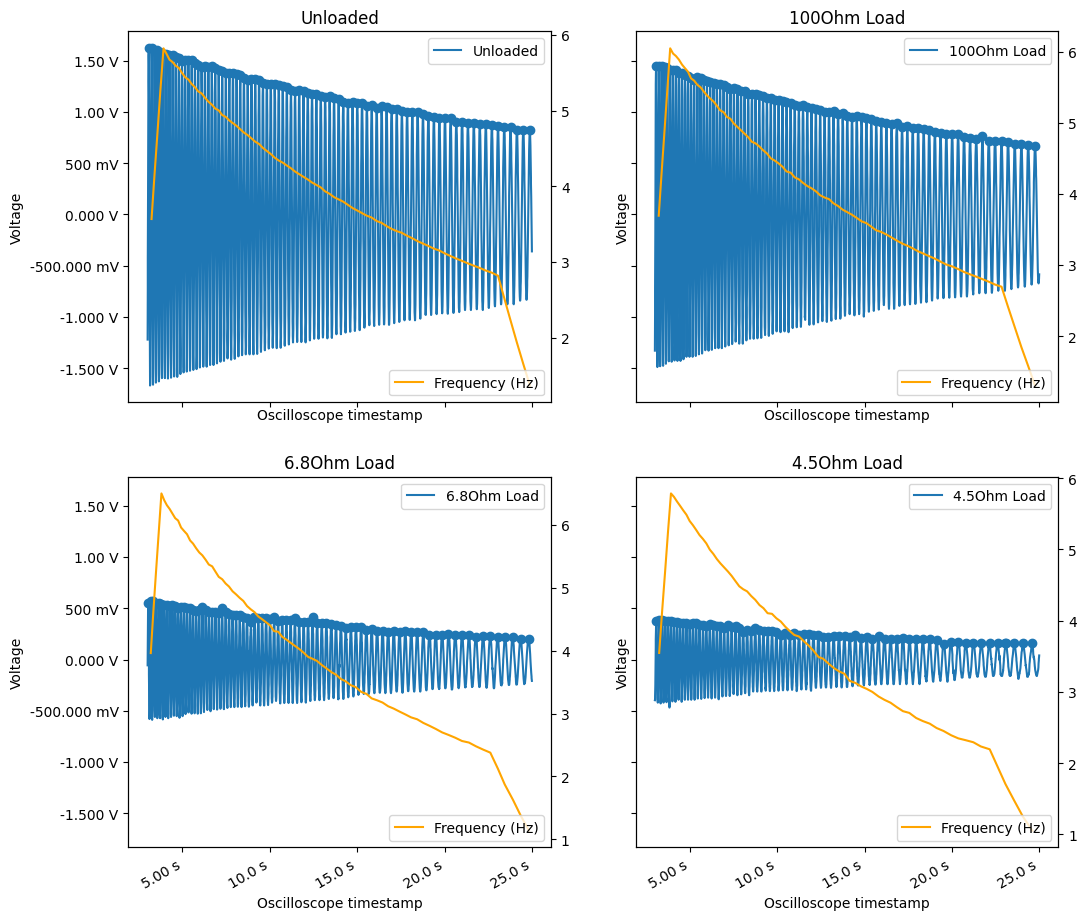

In [93]:
df_zoom = df[(df["t"] > 3) & (df["t"] < 25)]

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(nrows = 2, ncols = 2, sharex = True, sharey = True, figsize = (12, 12))
fig.autofmt_xdate()

def moving_average(x, w):
    w = int(w / 2) * 2
    convolution = np.convolve(x, np.ones(w), 'full') / w
    return convolution[int(w/2):-int(w/2)+1]

def find_y_crossing_monotonic_decrease(y_vals, y_target):
    left_side_idx = list(np.arange(len(y_vals))[y_vals > y_target])
    return left_side_idx[-1]

ax_list = [ax1, ax2, ax3, ax4]
channel_list = ["unloaded", "100Ohm", "6.8Ohm", "4.5Ohm"]
label_list = ["Unloaded", "100Ohm Load", "6.8Ohm Load", "4.5Ohm Load"]


amplitudes = []
for (ax, channel, label) in zip(ax_list, channel_list, label_list):
    helper.axes_labels("Oscilloscope timestamp", "s", "Voltage", "V", title = label, ax = ax)
    ax.plot(df_zoom["t"], df_zoom[channel], label = label)
    peak_idx = find_peaks(df_zoom[channel], distance = 25, width = 25)[0]
    df_peak_trace = df_zoom.iloc[peak_idx]
    frequency = 1 / (np.diff(df_peak_trace["t"]))
    smooth_frequency = moving_average(frequency[frequency < 20], 10)
    df_peak_trace_smooth_ts = df_peak_trace["t"][1:][frequency < 20]
    target_freq = 4 # Hz
    target_freq_idx = find_y_crossing_monotonic_decrease(y_vals = smooth_frequency, y_target = target_freq)
    print("your amplitude is")
    amplitude = moving_average(df_peak_trace[channel], 5)[df_peak_trace["t"] == list(df_peak_trace_smooth_ts)[target_freq_idx]][0]
    print(np.round(amplitude, 3))
    amplitudes.append(amplitude)

    ax.scatter(df_peak_trace["t"], df_peak_trace[channel])
    rax = ax.twinx()
    rax.plot(df_peak_trace["t"][1:][frequency < 20], smooth_frequency, color = "orange", label = "Frequency (Hz)")
    ax.legend(loc = "upper right")
    rax.legend(loc = "lower right")

def calculate_R1(Vin, Vout, R2):
    R1 = R2 * (Vin / Vout - 1)
    return R1

print("R1 =", calculate_R1(amplitudes[0] * units.volt, amplitudes[1] * units.volt, 100 * units.ohm))
print("R1 =", calculate_R1(amplitudes[0] * units.volt, amplitudes[2] * units.volt, 6.8 * units.ohm))
print("R1 =", calculate_R1(amplitudes[0] * units.volt, amplitudes[3] * units.volt, 1/(1/6.8 + 1/(2 * 6.8)) * units.ohm))